In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from auxiliar_func import preprocessing, downsampling
from plot_func import *

In [2]:
df = pd.read_csv('Census-Income-KDD.csv')
target = 'income_50k'
df_tr, df_te = train_test_split(df, test_size=0.3, random_state=42)

In [3]:
df_tr_pre = preprocessing(df_tr, scaling='minmax')
df_tr_pre = downsampling(df_tr_pre, ratio=0.7, type="random")
df_te_pre = preprocessing(df_te, scaling='minmax', remove_duplicates=False)

df_tr_pre = pd.get_dummies(df_tr_pre)
df_te_pre = pd.get_dummies(df_te_pre)
df_tr_pre, df_te_pre = df_tr_pre.align(df_te_pre, join='left', axis=1, fill_value=0)

In [4]:
df_tr_pre.shape, df_te_pre.shape

((78840, 483), (59857, 483))

## Adjusting a logistic regression model

In [5]:
X_train, y_train = df_tr_pre.drop(target, axis=1), df_tr_pre[target]
X_test, y_test = df_te_pre.drop(target, axis=1), df_te_pre[target]

# adjust a logistic regression model to the data
logreg = LogisticRegression(max_iter=100, random_state=42)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

C:\Users\joels\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Accuracy metrics:

Accuracy score:  0.9522194563710176


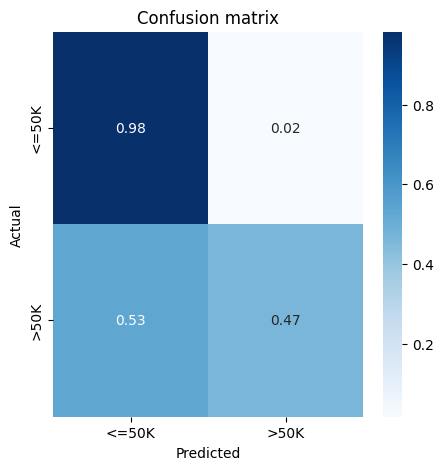

In [6]:
print('Accuracy score: ', accuracy_score(y_test, y_pred))
plot_conf_matrix(y_test, y_pred)